## 1. Creating our dataframe

### Importing relevant library

In [1]:
import pandas as pd
import os

### Loading the dataset

In [2]:
main_df = pd.read_csv('aqi.csv', parse_dates = ['date'], index_col = 'date')
main_df.head()

,so2,no2,rspm,spm,aqi
date,,,,,
2004-01-01,6.433505,58.231014,238.330000,398.000000,135.968035
2004-01-02,6.433505,58.231014,182.915000,346.500000,113.546396
2004-01-03,6.433505,58.231014,136.960411,343.926778,103.336731
2004-01-04,6.433505,58.231014,136.960411,343.926778,103.336731
2004-01-05,6.433505,58.231014,160.000000,340.000000,107.365595


### Preparing the dataset

In [3]:
SEQ_LEN=60 #no of days using to predict
FUTURE_PERIOD_PREDICT=7 #no of days predicting
RATIO_TO_PREDICT="aqi" # variable to be predicted

In [4]:
# if future aqi value is more than current then the target value is 0 otherwise it is 1
def classify(current, future):
    if float(future) > float(current):
        return 0
    else:
        return 1

In [5]:
# creating a future column with shift of 7 days
main_df['future'] = main_df[f"{RATIO_TO_PREDICT}"].shift(-FUTURE_PERIOD_PREDICT)

In [6]:
main_df.head(10)

,so2,no2,rspm,spm,aqi,future
date,,,,,,
2004-01-01,6.433505,58.231014,238.330000,398.000000,135.968035,91.988019
2004-01-02,6.433505,58.231014,182.915000,346.500000,113.546396,85.237846
2004-01-03,6.433505,58.231014,136.960411,343.926778,103.336731,103.336731
2004-01-04,6.433505,58.231014,136.960411,343.926778,103.336731,103.336731
2004-01-05,6.433505,58.231014,160.000000,340.000000,107.365595,90.715422
2004-01-06,6.433505,58.231014,141.335000,283.500000,91.634270,98.774930
2004-01-07,6.433505,58.231014,120.170000,259.000000,82.061584,103.182872
2004-01-08,6.433505,58.231014,123.165000,303.500000,91.988019,97.611495
2004-01-09,6.433505,58.231014,103.500000,291.000000,85.237846,88.903987


In [7]:
# mapping fuction classify to new column target
main_df['target'] = list(map(classify, main_df[f'{RATIO_TO_PREDICT}'], main_df["future"]))
main_df[[f"{RATIO_TO_PREDICT}","future","target"]].head(10)

,aqi,future,target
date,,,
2004-01-01,135.968035,91.988019,1
2004-01-02,113.546396,85.237846,1
2004-01-03,103.336731,103.336731,1
2004-01-04,103.336731,103.336731,1
2004-01-05,107.365595,90.715422,1
2004-01-06,91.634270,98.774930,0
2004-01-07,82.061584,103.182872,0
2004-01-08,91.988019,97.611495,0
2004-01-09,85.237846,88.903987,0


## 2. Normalizing, Creating Sequences and Balancing Data

In [8]:
times = sorted(main_df.index.values)

In [9]:
# index value at last 5% of the dataset
last_5pct = times[-int(0.05 * len(times))]
last_5pct

numpy.datetime64('2015-05-27T00:00:00.000000000')

### Spliting dataset into training and validation dataset

In [10]:
# validation dataframe
validation_main_df = main_df[(main_df.index >= last_5pct)]
# training dataframe
main_df = main_df[(main_df.index < last_5pct)]

### Importing relevant librarie

In [15]:
from sklearn import preprocessing
from collections import deque
import numpy as np
import random

### Defining a function to preprocess our training and validation dataset

In [16]:
def preprocess_df(df):
    df = df.drop('future',1)
    
    # scaling expect target column
    for col in df.columns:
        if col != 'target':
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    
    df.dropna(inplace=True)
    
    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)
    
    # creating our sequential data
    for i in df.values:
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])
            
    #random.shuffle(sequential_data)
    
    #balancing data
    buys = []
    sells = []
    
    for seq,target in sequential_data:
        if target == 0:
            sells.append([seq,target])
        elif target == 1:
            buys.append([seq,target])
            
    random.shuffle(buys)
    random.shuffle(sells)
    
    lower = min(len(buys), len(sells))
    
    buys = buys[:lower]
    sells = sells[:lower]
    
    sequential_data = buys + sells
    random.shuffle(sequential_data)
    
    X = []
    y = []
    
    for seq,target in sequential_data:
        X.append(seq)
        y.append(target)
    
    return np.array(X),y

### Preparing our data to feed into neural network

In [17]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)

In [18]:
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"validation dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

train data: 2824 validation: 124
dont buys: 1412, buys: 1412
validation dont buys: 62, buys: 62


In [19]:
train_y = np.asarray(train_y)
validation_y = np.asarray(validation_y)

## 3. Build and train the model

In [20]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [21]:
EPOCHS = 50
BATCH_SIZE = 100
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [22]:
model = Sequential()
# input layer
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

#hidden layer
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True,activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128, input_shape=(train_x.shape[1:]), activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

#output layer
model.add(Dense(2,activation='softmax'))

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])


history = model.fit(
                    train_x, train_y,
                    batch_size = BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(validation_x, validation_y))
                    #callbacks=[tensorboard,checkpoint])


Train on 2824 samples, validate on 124 samples
Epoch 1/50
2824/2824 [==============================] - 383s 136ms/sample - loss: 0.8265 - accuracy: 0.5078 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/50
2824/2824 [==============================] - 304s 107ms/sample - loss: 0.7877 - accuracy: 0.5326 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 3/50
2824/2824 [==============================] - 398s 141ms/sample - loss: 0.7494 - accuracy: 0.5220 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/50
2824/2824 [==============================] - 320s 113ms/sample - loss: 0.7249 - accuracy: 0.5375 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 5/50
2824/2824 [==============================] - 348s 123ms/sample - loss: 0.7029 - accuracy: 0.5552 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 6/50
2824/2824 [==============================] - 311s 110ms/sample - loss: 0.7077 - accuracy: 0.5482 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 7/50
2824/2824 [==============================]

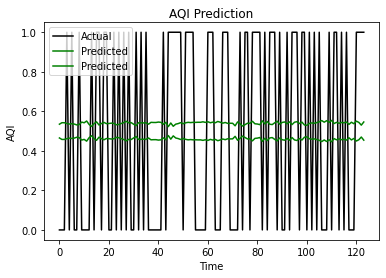

In [23]:
import matplotlib.pyplot as plt
predicted = model.predict(validation_x)
plt.plot(validation_y, color = 'black', label = 'Actual')
plt.plot(predicted, color = 'green', label = 'Predicted')
plt.title('AQI Prediction')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.show()

In [ ]:
#tensorboard = TensorBoard(log_dir=f"logs/{NAME}", profile_batch = 100000000)

#filepath = "RNN_Final-{epoch:02d}"
#checkpoint= ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))
#earlystopping = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)